In [71]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

random.seed("123")

In [77]:
split = "train"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [8]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


## Check a negative and a positive image

name of image: NNN15258.bmp


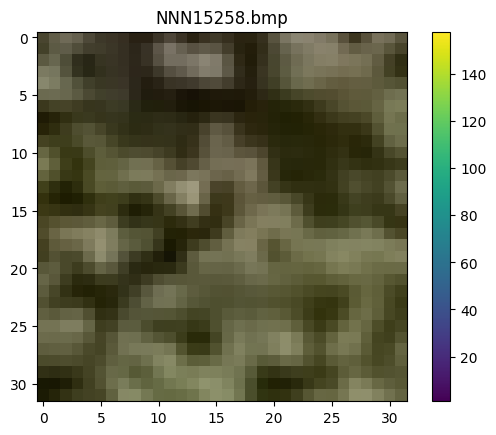

In [9]:
neg_image = plt.imread(os.path.join(folder_path,neg_files[0]))
plt.imshow(neg_image)
print(f'name of image: {neg_files[0]}')
plt.title(neg_files[0])
plt.colorbar()
plt.show()

name of image: FO006632.bmp


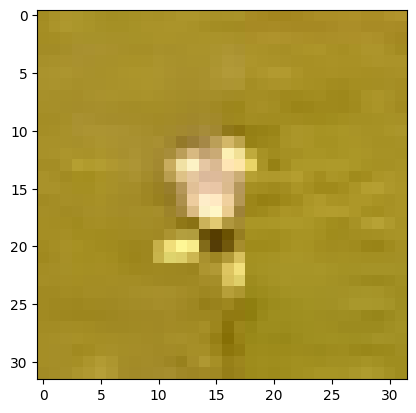

In [10]:
pos_image = plt.imread(os.path.join(folder_path,pos_files[0]))
plt.imshow(pos_image)
plt.title(pos_files[0])
plt.colorbar()
plt.show()

# Check the mean values

In [20]:
#read binary proto file with numpy
mean_values = np.fromfile(f"{base_path}/mean.binaryproto", dtype=np.float32)

mean_values = mean_values[:-2]
# reshape the mean_values array to match the shape of the image
mean_values = mean_values.reshape(neg_image.shape)

array([[[ 4.23189804e-37,  1.35631461e-19,  5.61251602e+01],
        [-1.53538289e-28, -4.53162023e-08,  3.59032676e+21],
        [ 3.42401289e+15, -1.18794655e-02, -1.42993921e-37],
        ...,
        [ 8.56029865e+14, -8.16376896e+08, -1.10639449e-11],
        [-1.03040693e-20,  5.85716233e-34, -2.70113280e-15],
        [-3.57491053e-38,  1.53541587e-28,  2.57600118e-21]],

       [[-1.57907707e+34,  5.60999948e+19, -2.24400771e+20],
        [ 7.42454780e-04, -9.59597905e-30, -6.75253977e-16],
        [ 2.63769823e-18,  7.78514099e+02, -6.02347290e+28],
        ...,
        [-1.13304663e-08,  1.46438758e-34,  1.08050936e-14],
        [-4.53192719e-08, -2.52661245e+35, -1.68825207e-16],
        [ 9.15194314e-36,  3.76484794e+27,  3.74854687e-32]],

       [[ 2.04088512e+08, -6.91474330e-13,  1.43614005e+22],
        [ 7.78507812e+02,  9.82616545e-27, -1.27550790e+07],
        [-2.24388685e+20, -1.72861996e-13,  2.63767900e-18],
        ...,
        [ 5.72197561e-37, -6.12376537e-39,

In [22]:
pos_image

array([[[163, 140,  34],
        [169, 146,  40],
        [173, 150,  44],
        ...,
        [170, 141,  37],
        [175, 146,  42],
        [177, 148,  44]],

       [[165, 142,  36],
        [171, 148,  42],
        [174, 152,  46],
        ...,
        [168, 139,  37],
        [169, 140,  38],
        [168, 139,  37]],

       [[164, 141,  35],
        [165, 142,  36],
        [167, 144,  39],
        ...,
        [172, 144,  41],
        [167, 139,  36],
        [164, 136,  33]],

       ...,

       [[165, 142,  38],
        [165, 142,  40],
        [165, 142,  39],
        ...,
        [155, 137,  27],
        [156, 138,  28],
        [160, 142,  34]],

       [[165, 142,  38],
        [165, 142,  40],
        [165, 142,  39],
        ...,
        [163, 145,  35],
        [159, 141,  31],
        [159, 141,  31]],

       [[162, 139,  37],
        [164, 141,  39],
        [166, 143,  41],
        ...,
        [170, 152,  42],
        [164, 146,  36],
        [159, 141,  31]]

In [29]:
print(f'max of mean values: {mean_values.max()} in pos {mean_values.argmax()}')
print(f'min of mean values: {mean_values.min()} in pos {mean_values.argmin()}')

max of mean values: 2.5920690282238314e+38 in pos 2382
min of mean values: -2.592727395239566e+38 in pos 2356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


name of image: NNN15258.bmp


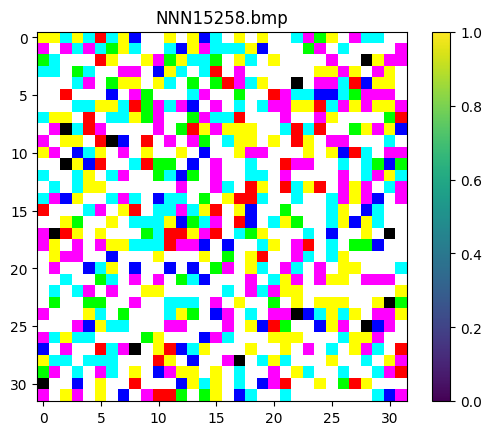

In [21]:
neg_image = plt.imread(os.path.join(folder_path,neg_files[0]))
plt.imshow(neg_image - mean_values)
print(f'name of image: {neg_files[0]}')
plt.title(neg_files[0])
plt.colorbar()
plt.show()

# Create simple dataset (white noice background with one random positive and else negatives in a 96X96 image)

In [93]:
def write_to_xml(image_name, bboxes, dabase_name, save_folder, xml_template='pascal_voc_template.xml'):
    # read xml file
    tree = ET.parse(xml_template)
    root = tree.getroot()

    # modify
    folder = root.find('folder')
    folder.text = 'Annotations'

    fname = root.find('filename')
    fname.text = image_name

    src = root.find('source')
    database = src.find('database')
    database.text = dabase_name

    h, w = bboxes[0][5]
    d = 3
    size = root.find('size')
    width = size.find('width')
    width.text = str(w)
    height = size.find('height')
    height.text = str(h)
    depth = size.find('depth')
    depth.text = str(d)

    for box in bboxes:
        # append object
        obj = ET.SubElement(root, 'object')

        name = ET.SubElement(obj, 'name')
        name.text = box[0]

        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = str(0)

        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = str(0)

        bndbox = ET.SubElement(obj, 'bndbox')

        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(box[1]))

        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(box[2]))

        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(box[3]))

        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(box[4]))

    # save .xml to anno_path
    anno_path = os.path.join(save_folder, "annotations", image_name.split('.')[0] + '.xml')
    tree.write(anno_path)

In [98]:
split = "train"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [99]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 40658
dataset negative files: 58302


In [104]:
# create an empty image with the desired shape (32, 32, 3)
image_size = (96, 96, 3)
background = np.zeros(image_size, dtype=np.uint8)

# # fill the image with random RGB values
# image[:, :, 0] = np.random.randint(0, 256, (32, 32)) # fill the Red channel with random values
# image[:, :, 1] = np.random.randint(0, 256, (32, 32)) # fill the Green channel with random values
# image[:, :, 2] = np.random.randint(0, 256, (32, 32)) # fill the Blue channel with random values

# add white noise to the image
noise = np.random.normal(0, 60, image_size)
background = background + noise

# clip the values to make sure they stay within the valid range (0-255)
background = np.clip(background, 0, 255).astype(np.uint8)

In [105]:
background.max()

255

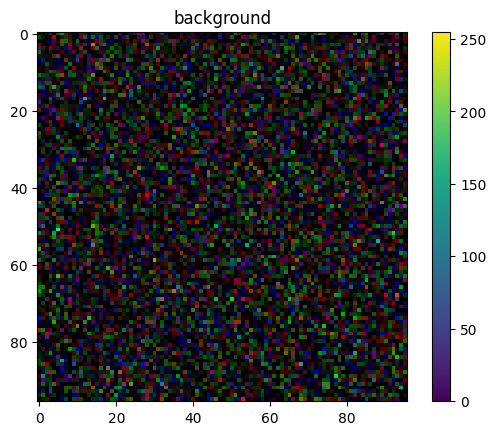

In [106]:
plt.imshow(background)
plt.title(f'background')
plt.colorbar()
plt.show()

dataset_name: Football
bboxes :[['player', 24, 37, 56, 69, (96, 96)]]


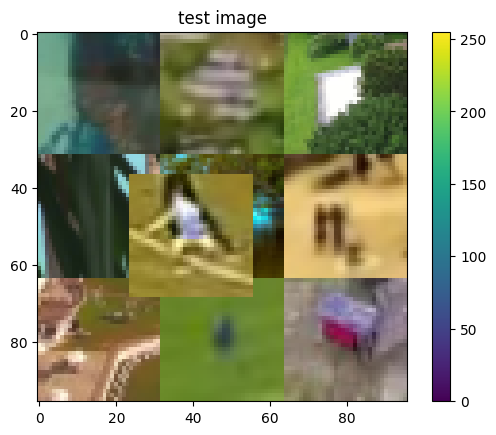

In [107]:
# ADD random negative images
neg_idx = list(range(len(neg_files)))
random.shuffle(neg_idx)

pos_idx = list(range(len(pos_files)))
random.shuffle(pos_idx)

# number_of_negs_width = random.randint(0,9)
# number_of_negs_height = random.randint(0,9)
new_image = background.copy()

number_of_negs_width = 3 #Add code for random number of neg images
number_of_negs_height = 3

image = 0
for width in range(number_of_negs_width):
    for height in range(number_of_negs_height):
        neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
        neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

        starting_width = width*neg_image.shape[0]
        starting_height = height*neg_image.shape[1]
        new_image[starting_width:starting_width+neg_image.shape[0], starting_height:starting_height+neg_image.shape[1], :] = neg_image

number_of_pos_img = 1
bboxes = []
for pos_img in range(number_of_pos_img):
    pos_image_idx = image #Add code for random number of pos images
    pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))

    position_of_pos = (random.randint(0,image_size[0]-pos_image.shape[0]), random.randint(0,image_size[1]-pos_image.shape[1]))
    new_image[position_of_pos[0]:position_of_pos[0]+pos_image.shape[0], position_of_pos[1]:position_of_pos[1]+pos_image.shape[1], :] = pos_image
    bboxes.append(["player", position_of_pos[1], position_of_pos[0], position_of_pos[1]+pos_image.shape[1], position_of_pos[0]+pos_image.shape[0], (image_size[0], image_size[1])])


print(f"dataset_name: {dataset_name}")
print(f"bboxes :{bboxes}")

plt.imshow(new_image)
plt.title(f'test image')
plt.colorbar()
plt.show()

In [108]:
save_folder = f'{base_dataset_path}/96x96_1pos_9neg/{split}'

random.seed("123")
# ADD random negative images
neg_idx = list(range(len(neg_files)))
random.shuffle(neg_idx)

pos_idx = list(range(len(pos_files)))
random.shuffle(pos_idx)

# number_of_negs_width = random.randint(0,9)
# number_of_negs_height = random.randint(0,9)
name_prefix = "NEW"
new_image = background.copy()
for image in range(pos_counter):
    number_of_negs_width = 3 #Add code for random number of neg images
    number_of_negs_height = 3
    new_image = background
    for width in range(number_of_negs_width):
        for height in range(number_of_negs_height):
            neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
            neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))
            starting_width = width*neg_image.shape[0]
            starting_height = height*neg_image.shape[1]
            new_image[starting_width:starting_width+neg_image.shape[0], starting_height:starting_height+neg_image.shape[1], :] = neg_image

    number_of_pos_img = 1
    bboxes = []
    for pos_img in range(number_of_pos_img):
        pos_image_idx = image #Add code for random number of pos images
        pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))

        position_of_pos = (random.randint(0,image_size[0]-pos_image.shape[0]), random.randint(0,image_size[1]-pos_image.shape[1]))
        new_image[position_of_pos[0]:position_of_pos[0]+pos_image.shape[0], position_of_pos[1]:position_of_pos[1]+pos_image.shape[1], :] = pos_image
        bboxes.append(["player", position_of_pos[1], position_of_pos[0], position_of_pos[1]+pos_image.shape[1], position_of_pos[0]+pos_image.shape[0], (image_size[0], image_size[1])])

    image_name = f'{name_prefix}{image:05}.bmp'
    plt.imsave(f"{save_folder}/images/{image_name}", new_image)
    write_to_xml(image_name, bboxes, dataset_name, f"{save_folder}", xml_template='pascal_voc_template.xml')